## Rossmann case - Forecast Sales analysis
Olá! Seja bem-vindo(a)!

Este projeto foi desenvolvido com foco no desenvolvimento do meu portfólio de análise de dados, demonstrando minhas habilidades em Análise Exploratória de Dados com Python e utilização de estatística e regressão linear para previsão de demanda.

### Contexto de negócio
A Rossmann é uma das maiores redes de farmacias da Europa, com mais de 3.000 lojas em operação. 
Para planejar um ciclo de reformas, o CFO da empresa precisa saber com antecedência quanto cada loja vai faturar nas próximas seis semanas, informação essencial para uma alocação de orçamento inteligente. O objetivo deste projeto é construir um modelo de regressão linear que faça essa previsão com base em variáveis como promoções, feriados, sazonalidade e presença de concorrentes.

### Perguntas de negócio a serem respondidas
    1. Quanto cada loja vai vender nas próximas 6 semanas?

### Etapas da Análise

- Importação de bibliotecas e carregamento dos dados
- Limpeza, tratamento e preparação
- Análise Exploratória de Dados (EDA)
- Preparação dos dados
- Modelagem com Regressão Linear
- Conclusões Regressão
- Conclusões Gerais


Fique à vontade para entrar em contato comigo. Boa leitura!

---

### 📖 Carregamento das bibliotecas.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 📥 Importação de dados

In [26]:
df_train = pd.read_csv('../sales_forecast_rossmann/rossmann-store-sales-files/train.csv', sep=',')
df_train

C:\Users\diogo\AppData\Local\Temp\ipykernel_25816\4023907617.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../sales_forecast_rossmann/rossmann-store-sales-files/train.csv', sep=',')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


### 🧹Limpeza, tratamento e preparação
1. Valores ausentes.
2. Valores duplicados.
3. Tipo de dados.
4. Outliers.

In [27]:
#1 > ok
df_train.isnull().sum()
#2 > ok
df_train.duplicated().sum()

np.int64(0)

In [28]:
#2 > ok
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['StateHoliday'] = df_train['StateHoliday'].replace({'0':'0','a':'1','b':'1','c':'1'})
df_train['StateHoliday'] = df_train['StateHoliday'].astype(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  int64         
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 69.8 MB


In [29]:
df_train = df_train[df_train['Sales'] != 0]
sales_by_client_info = df_train.groupby('Customers')['Sales'].sum().describe().astype(int)
sales_by_client_info
# Identifiquei uma distribuição bem assimetrica como o Desvio padrão (std), muito diferente da média, portanto,
# há necessidade de remoção de Outliers para que não afete as projeções 



count        4083
mean      1438447
std       2511721
min            46
25%         76353
50%        218009
75%       1451833
max      14597326
Name: Sales, dtype: int64

In [30]:
sales_by_client = df_train.groupby('Customers')['Sales'].sum()
sales_by_client.head()

Customers
8      46
13    124
18    133
36    297
40    286
Name: Sales, dtype: int64

In [31]:
#Remoção de outliers superiores com base no IQR
Q1 = sales_by_client.quantile(0.25)
Q3 = sales_by_client.quantile(0.75)
IQR = Q3 - Q1
IQR

upper_limit = Q3 + 5 * IQR
lower_limit = Q1 - 5 * IQR 

valid_clients = sales_by_client[
    (sales_by_client >= lower_limit) &
    (sales_by_client <= upper_limit)
].index

df_train = df_train[df_train['Customers'].isin(valid_clients)]
df_train.info()

# Ainda sendo bastante permissivo com o multiplicador do IQR (5) sendo o padrão 1.5,
# a quantidade de redução de linhas é muito grande (de 1.017.209 para 671.776 redução de 34%  das linhas )
# entende-se que a distribuição desses dados é muito assimetrica por padrão do tipo de negócio.
# ou seja, os dados devem ser mantidos em sua completude.

# Obs: testar futuramente transformação logarítmica

<class 'pandas.core.frame.DataFrame'>
Index: 671776 entries, 2 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          671776 non-null  int64         
 1   DayOfWeek      671776 non-null  int64         
 2   Date           671776 non-null  datetime64[ns]
 3   Sales          671776 non-null  int64         
 4   Customers      671776 non-null  int64         
 5   Open           671776 non-null  int64         
 6   Promo          671776 non-null  int64         
 7   StateHoliday   671776 non-null  int64         
 8   SchoolHoliday  671776 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 51.3 MB


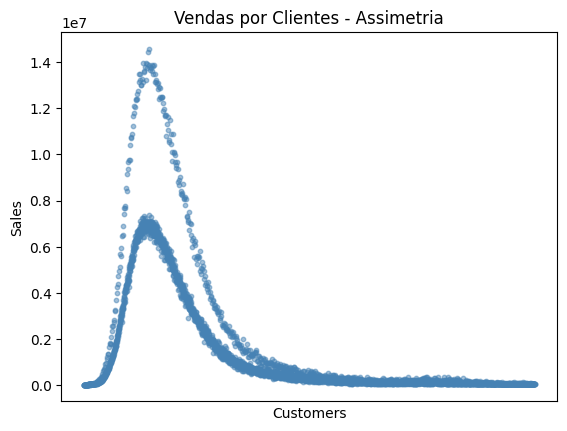

In [32]:
# Segue grafico para entendimento do tamanho da assimetria de distribuição entre clientes.

plt.Figure(figsize=(12,5))

plt.scatter(range(len(sales_by_client)),sales_by_client, alpha=0.5, color='steelblue', s=10)

plt.title('Vendas por Clientes - Assimetria')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.xticks([])
plt.show()

### 🔎Análise Exploratória de Dados (EDA)

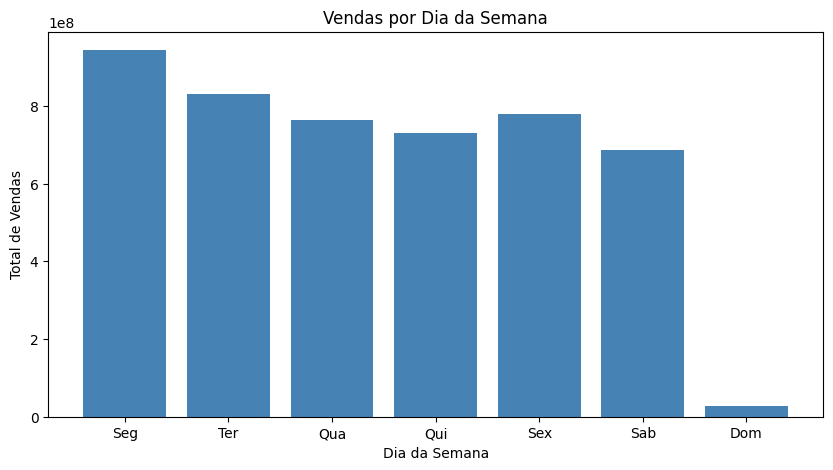

In [33]:
# Análise de vendas por dia da semana
df_train.groupby('DayOfWeek')['Sales'].sum()

sales_by_day = df_train.groupby('DayOfWeek')['Sales'].sum()

plt.figure(figsize=(10, 5))
plt.bar(sales_by_day.index, sales_by_day.values, color='steelblue')

plt.title('Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Total de Vendas')
plt.xticks(sales_by_day.index, ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
plt.show()


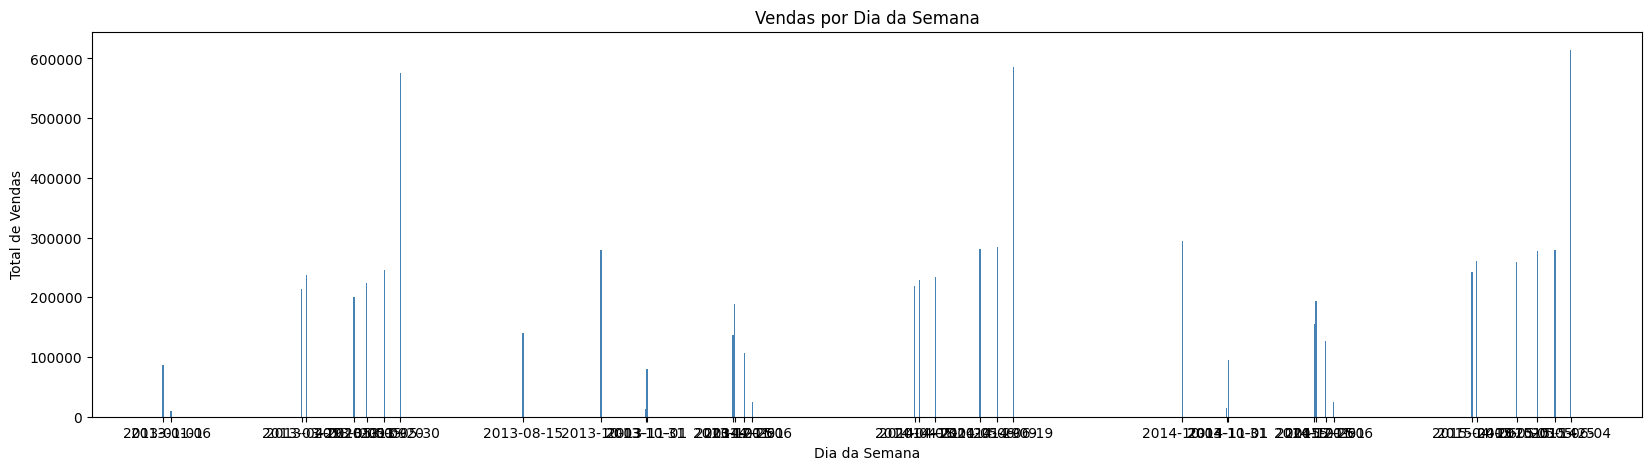

In [ ]:
# Análise de vendas Feriado/N Feriado
# "StateHoliday","SchoolHoliday"
df_train.groupby('StateHoliday')['Sales'].sum()

sales_by_holiday = df_train[df_train['StateHoliday']==1].groupby(df_train['Date'].dt.strftime('%d/%m'))['Sales'].sum()
sales_by_holiday = sales_by_holiday.sort_values(ascending=False)

plt.figure(figsize=(20, 5))
plt.bar(sales_by_holiday.index, sales_by_holiday.values, color='steelblue')

plt.title('Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Total de Vendas')
plt.xticks(sales_by_holiday.index)
plt.show()

# Podemos notar que alguns feriados do estado, possuem um padrão de aumento de vendas ao longo dos anos.
# Alguns feriados mais que outros.

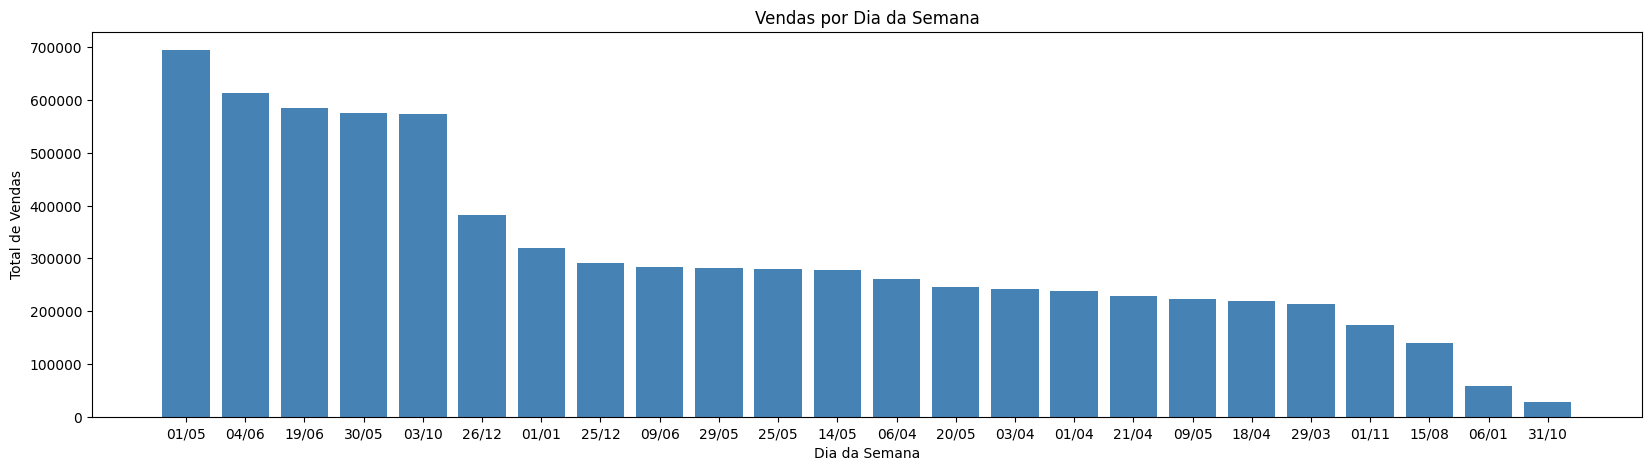

In [ ]:
# Análise de vendas Feriado/N Feriado
# "StateHoliday","SchoolHoliday"
df_train.groupby('StateHoliday')['Sales'].sum()

sales_by_holiday = df_train[df_train['StateHoliday']==1].groupby(df_train['Date'].dt.strftime('%d/%m'))['Sales'].sum()
sales_by_holiday = sales_by_holiday.sort_values(ascending=False)

plt.figure(figsize=(20, 5))
plt.bar(sales_by_holiday.index, sales_by_holiday.values, color='steelblue')

plt.title('Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Total de Vendas')
plt.xticks(sales_by_holiday.index)
plt.show()

# Os feriados que possuem um padrão maior de vendas são 01/05; 04/06; 19/06; 30/05 e 03/10.
# Sabendo disso, faza sentido uma melhor preparação do negócio para antecipação e impulsão das vendas nesses dias.
# Assim como, entender o motivo dos outros feriados, não aumentarem as vendas na mesma proporção.

In [ ]:
# Análise de Promo / N Promo